# Violence Against Women

### Table of Contents
1. [Set Up](#Set+Up)
2. [Split Datasetd](#Split_Datasetd)
3. [Remove Outliers](#Remove_Outliers)
4. [Impute](#Impute)
5. [Scale](#Scale)
6. [P.C.A.](#P.C.A.)
7. [Data Mining](#Data_Mining)
    1. [Logistic Regression](#Logistic_Regression)
    2. [k-Nearest Neighbors](#k-Nearest_Neighbors)
    3. [Disicion Tree](#Disicion_Tree)
    4. [Support Vector Machine](#Support_Vector_Machine)
    5. [Random Forest](#Random_Forest)
    6. [XGBoosting](#XGBoosting)
8. [Evaluation-Interpretation](#Evaluation-Interpretation)
9. [Prediction](#Prediction)
    1. [Merge All Three SubDatasets Back to One](#Merge_All_Three_SubDatasets_Back_to_One)
    2. [Save New Dataset as .csv](#Save_New_Dataset_as_.csv)

<a id="Set_Up"></a>
## Set_Up

In [ ]:
# Imports
# Basics
import numpy as np
import pandas as pd


# Plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Cross validation
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read Preprocessed Data from WAV_Preprocessed.csv file
data = pd.read_csv('datasets/WAV_Preprocessed.csv', 
                    # Specify the first row as the header
                    header=0
                    )

### Split_Datasets

In [211]:
# split sets X(train, test, predic) + y(train, test, predic)

In [212]:
prediction_set = data.loc[data['Outcome'] == outcome_encoder['ANY']]
train_set = data.loc[data['Outcome'] != outcome_encoder['ANY']]

X_pred = prediction_set.drop('Outcome', axis=1)
y_pred = prediction_set['Outcome']

X = train_set.drop('Outcome', axis=1)
y = train_set['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#shape of dataset
print('X_train: '  + str(X_train.shape))
print('y_train: '  + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('y_test:  '  + str(y_test.shape))
print('X_pred: '   + str(X_pred.shape))
print('y_pred: '   + str(y_pred.shape))

X_train: (435, 68)
y_train: (435,)
X_test:  (109, 68)
y_test:  (109,)
X_pred: (1472, 68)
y_pred: (1472,)


### Remove_Outliers

<AxesSubplot:xlabel='Observation_Value'>

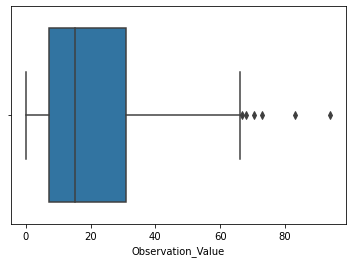

In [213]:
sns.boxplot(x=X_train['Observation_Value'])

In [214]:
Q1 = X_train['Observation_Value'].quantile(0.25)
Q3 = X_train['Observation_Value'].quantile(0.75)
IQR = Q3 - Q1

print(f'Range: {IQR}')
print(f'Q1: {Q1}')
print(f'Q3: {Q3}')

Range: 23.65
Q1: 7.275
Q3: 30.925


In [215]:
lower_bound = Q1 - (1.5 * IQR) 
upper_bound = Q3 + (1.5 * IQR)

print(f'Bounds: [{lower_bound},{upper_bound}]')
print(f'Bounds Range: {upper_bound-lower_bound}')

Bounds: [-28.199999999999996,66.39999999999999]
Bounds Range: 94.6


#### Locate the rows with outliers

In [216]:
# outlier rows indexies
outliers_rows = (X_train['Observation_Value'].index[(X_train['Observation_Value'] < lower_bound) |(X_train['Observation_Value'] > upper_bound)]).tolist()
print(f'There are {len(outliers_rows)} outliers:')
print(outliers_rows)

There are 6 outliers:
[1720, 1866, 1865, 1551, 1089, 1344]


In [217]:
# drop the outliers
X_train = X_train.drop(outliers_rows, axis=0)
y_train = y_train.drop(outliers_rows, axis=0)

In [218]:
# Check...
print(X_train.shape[0] == y_train.shape[0])
print(X_train.shape[0])

True
429


<AxesSubplot:xlabel='Observation_Value'>

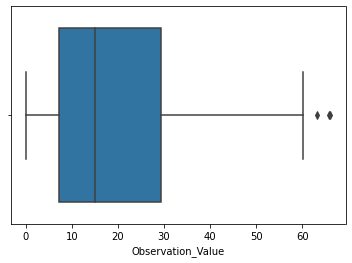

In [219]:
sns.boxplot(x=X_train['Observation_Value']) # seems better

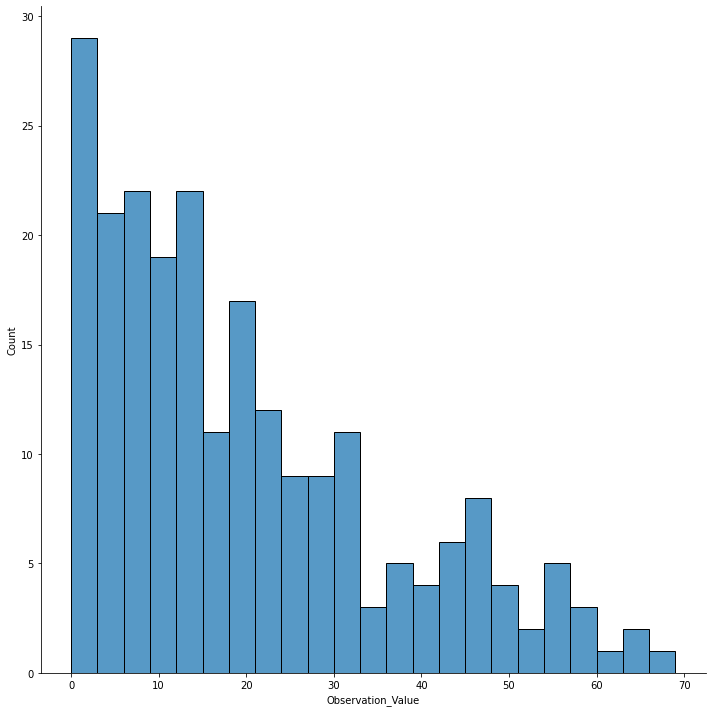

In [220]:
sns.displot(X_train, x='Observation_Value', binwidth=3, height=10)

### Impute

In [221]:
# define imputer
imp = IterativeImputer(max_iter=10, random_state=0)

In [222]:
# Fit and transform on train set
imputed_array = imp.fit_transform(X_train)

In [223]:
# Convert to Dataframe again
X_train = pd.DataFrame(imputed_array, index=X_train.index, columns=X_train.columns)

In [224]:
# transform test and predict set

In [225]:
# test set
imputed_array = imp.transform(X_test)
X_test = pd.DataFrame(imputed_array, index=X_test.index, columns=X_test.columns)

# predict set
imputed_array = imp.transform(X_pred)
X_pred = pd.DataFrame(imputed_array, index=X_pred.index, columns=X_pred.columns)

### Scale 

In [226]:
# define min max scalers
scaler = MinMaxScaler()

# Fit and transform training data
scaled_array = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_array, index=X_train.index, columns=X_train.columns)

In [227]:
# transform test and predict set

In [228]:
# test set
scaled_array = scaler.transform(X_test)
X_test = pd.DataFrame(scaled_array, index=X_test.index, columns=X_test.columns)

# predict set
scaled_array = scaler.transform(X_pred)
X_pred = pd.DataFrame(scaled_array, index=X_pred.index, columns=X_pred.columns)

### P.C.A.

In [229]:
# define PCA
pca = PCA()
pca = pca.fit(X_train)

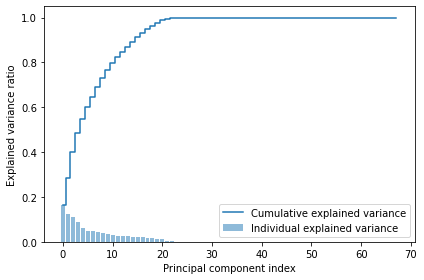

In [230]:
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [231]:
total_var = 0

for i, var in enumerate(exp_var_pca):
    total_var += var
    if total_var > .99:
        print(f'For {i} components there is over 99% of information kept!')
        break

For 21 components there is over 99% of information kept!


In [232]:
pca = PCA(n_components=21)

In [233]:
# Fit and transform training data

In [234]:
pca_array = pca.fit_transform(X_train)
X_train = pd.DataFrame(pca_array, index=X_train.index)

In [235]:
# transform test and predict set

In [236]:
# test set
pca_array = pca.transform(X_test)
X_test = pd.DataFrame(pca_array, index=X_test.index)

# predict set
pca_array = pca.transform(X_pred)
X_pred = pd.DataFrame(pca_array, index=X_pred.index)

### Data_Mining

#### Logistic_Regression

In [237]:
%%time

# Define the multinomial logistic regression model
logisticRegressor = LogisticRegression(multi_class='multinomial',
                                       random_state=96,
                                       class_weight='balanced')

# Define model parameters for the grid
param_grid = {'penalty':['l1', 'l2'],
              'C': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]}

# Define the (10-Fold) Cross Validation Grid Search
search = GridSearchCV(estimator=logisticRegressor,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)

# Lets search
search.fit(X_train,
           y_train)

print(search.best_params_)
print(search.best_score_)

logisticRegressor = search.best_estimator_

{'C': 0.6, 'penalty': 'l2'}
0.22159468438538205
Wall time: 708 ms


### k-Nearest_Neighbors

In [238]:
%%time

# Define the multinomial logistic regression model
kNearestNeighbors = KNeighborsClassifier(metric='minkowski')

# Define model parameters for the grid
param_grid = {'n_neighbors':list(range(5,35)), # sqrt(435)~20 => [20-15,20+15] = [5,35]
              'weights':['distance','uniform'],
              'p':[1,2,3,4,5,6,7,8,9,10]}

# Define the (10-Fold) Cross Validation Grid Search
search = GridSearchCV(estimator=kNearestNeighbors,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)

# Lets search
search.fit(X_train,
           y_train)

print(search.best_params_)
print(search.best_score_)

kNearestNeighbors = search.best_estimator_

{'n_neighbors': 32, 'p': 6, 'weights': 'uniform'}
0.3030454042081949
Wall time: 1min


### Disicion_Tree

In [239]:
%%time

# Define the multinomial logistic regression model
decisionTree = DecisionTreeClassifier(random_state=96,
                                      class_weight='balanced')

# Define model parameters for the grid
param_grid = {'criterion':['gini','entropy'],
              'splitter':['best','random'],
              'max_depth':[2,3,4,5,6,7,8],
              'min_samples_split':[2,3,4],
              'min_samples_leaf':[2,3,4,5,6]}

# Define the (10-Fold) Cross Validation Grid Search
search = GridSearchCV(estimator=decisionTree,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)

# Lets search
search.fit(X_train,
           y_train)

print(search.best_params_)
print(search.best_score_)

decisionTree = search.best_estimator_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2, 'splitter': 'random'}
0.3218715393133998
Wall time: 21.9 s


### Support_Vector_Machine

In [240]:
%%time

# Define the multinomial logistic regression model
supportVectorMachine = SVC(random_state=96,
                           class_weight='balanced')

# Define model parameters for the grid
param_grid = [{'kernel':['linear'],
               'C':[0.125, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]},
              {'kernel':['poly'],
               'degree':[2,3,4,5,6,7,8],
               'coef0':[0,1],
               'gamma':[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.5, 1, 2, 4],
               'C':[0.125, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]},
              {'kernel':['rbf'],
               'gamma':[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.5, 1, 2, 4],
               'C':[0.125, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]},
              {'kernel':['sigmoid'],
               'coef0':[0,1],
               'gamma':[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.5, 1, 2, 4],
               'C':[0.125, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]},]

# Define the (10-Fold) Cross Validation Grid Search
search = GridSearchCV(estimator=supportVectorMachine,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)

# Lets search
search.fit(X_train,
           y_train)

print(search.best_params_)
print(search.best_score_)

supportVectorMachine = search.best_estimator_

{'C': 0.125, 'kernel': 'linear'}
0.33322259136212623
Wall time: 6min 22s


### Random_Forest

In [241]:
%%time

# Define the multinomial logistic regression model
randomForest = RandomForestClassifier(random_state=96,
                                      class_weight='balanced')

# Define model parameters for the grid
param_grid = {'n_estimators':[5,10,15,20,25,30,35,40],
              'criterion':['gini','entropy'],
              'max_depth':[3,4,5,6,7,8],
              'min_samples_split':[2,3,4,5],
              'min_samples_leaf':[1,2,3]}

# Define the (10-Fold) Cross Validation Grid Search
search = GridSearchCV(estimator=randomForest,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)

# Lets search
search.fit(X_train,
           y_train)

print(search.best_params_)
print(search.best_score_)

randomForest = search.best_estimator_

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}
0.28211517165005534
Wall time: 7min 34s


### XGBoosting

In [242]:
%%time

# Define the multinomial logistic regression model
xGBoost = XGBClassifier(random_state=96,
                        class_weight='balanced')

# Define model parameters for the grid
param_grid = {'n_estimators':[125,130,135,140,145,150,155]}

# Define the (10-Fold) Cross Validation Grid Search
search = GridSearchCV(estimator=xGBoost,
                      param_grid=param_grid,
                      scoring='accuracy',
                      cv=10)

# Lets search
search.fit(X_train,
           y_train)

print(search.best_params_)
print(search.best_score_)

xGBoost = search.best_estimator_

[20:56:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:56:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly p

[20:56:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:56:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly p

[20:56:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:56:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly p

[20:56:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:56:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly p

[20:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly p

[20:57:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:57:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly p

## Evaluation-Interpretation

In [243]:
def evaluation_func(model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    
    y_hat = model.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test,y_hat)
    precision = metrics.precision_score(y_test,y_hat,average='macro')
    recall = metrics.recall_score(y_test,y_hat,average='macro')
    f1 = metrics.f1_score(y_test,y_hat,average='macro')
    
    return [accuracy,precision,recall,f1]

In [244]:
models = [logisticRegressor,
          kNearestNeighbors,
          decisionTree,
          supportVectorMachine,
          randomForest,
          xGBoost]

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for model in models:
    # calculate scores
    [acc,pre,rec,f1] = evaluation_func(model, X_train, X_test, y_train, y_test)
    # append to correct lists
    accuracy_scores.append(acc)
    precision_scores.append(pre)
    recall_scores.append(rec)
    f1_scores.append(f1)

[20:57:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:57:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


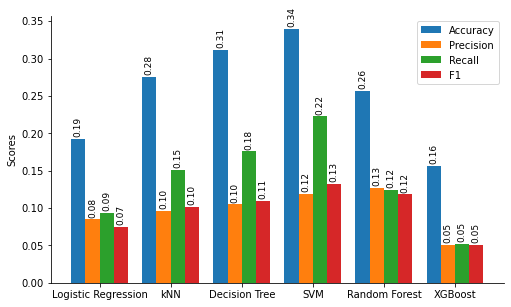

<Figure size 432x288 with 0 Axes>

In [245]:
labels = ['Logistic Regression', 'kNN', 'Decision Tree', 'SVM', 'Random Forest', 'XGBoost']
x = np.arange(len(labels))*2.5  # the label locations
width = 0.50  # the width of the bars

# Plot
fig, ax = plt.subplots()

# Form group bars
rects1 = ax.bar(x - 0.75, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x - 0.25, precision_scores, width, label='Precision')
rects3 = ax.bar(x + 0.25, recall_scores, width, label='Recall')
rects4 = ax.bar(x + 0.75, f1_scores, width, label='F1')

# Add some text for labels and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Define bar labels properties
ax.bar_label(rects1, fmt='%.2f', fontsize=9, rotation=90, padding=2)
ax.bar_label(rects2, fmt='%.2f', fontsize=9, rotation=90, padding=2)
ax.bar_label(rects3, fmt='%.2f', fontsize=9, rotation=90, padding=2)
ax.bar_label(rects4, fmt='%.2f', fontsize=9, rotation=90, padding=2)

fig.tight_layout(rect=(0,0,1.2,1.1))
sns.despine()
plt.show()

plt.savefig('Scores_by_Algorythm.jpg')

## Prediction

In [246]:
X_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,-0.095146,-0.270775,-0.160796,0.056499,0.263191,0.094090,0.193086,0.202750,0.450894,-0.162408,-0.019386,-0.189745,0.203501,-0.014376,0.328980,0.594006,-0.500987,0.458466,-0.144457,0.144544,-0.133649
1,0.184818,-0.178934,-0.254737,0.034532,0.331010,0.116268,0.194603,-0.474799,0.634516,-0.238699,0.059973,-0.154528,0.179162,-0.017794,0.309899,0.595497,-0.511303,0.511923,-0.148456,0.084257,-0.133387
2,0.237574,-0.115207,-0.200532,-0.011499,0.130076,-0.009226,0.228233,0.881630,0.304834,-0.129532,0.102924,-0.195364,0.180656,-0.004536,0.356172,0.546696,-0.459488,0.420419,-0.159465,0.086078,-0.159865
3,0.285659,-0.150339,-0.289820,0.029470,0.353184,0.111596,0.173367,-0.434884,0.688644,-0.191000,0.428473,-0.128052,0.172569,-0.030816,0.113693,0.345776,-0.362756,1.135812,-0.271234,0.084436,-0.036880
4,0.345141,-0.075935,-0.225586,-0.029478,0.132346,-0.027542,0.216382,0.928776,0.366435,-0.107082,0.489098,-0.160765,0.157516,-0.016043,0.160051,0.284551,-0.303923,1.043480,-0.284147,0.077171,-0.083043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,-0.049534,0.163366,0.560462,0.155557,0.536468,0.171218,-0.005066,-0.043865,-0.171883,0.555886,0.059725,0.391102,-0.119554,-0.015795,0.044403,-0.442672,-0.457955,-0.061588,0.066864,0.179926,-0.149922
2012,-0.060819,0.145451,0.543632,0.177232,0.569866,0.194113,-0.020814,-0.056000,-0.184423,0.598255,0.030067,0.377471,-0.091788,-0.018338,0.044259,-0.421826,-0.469732,-0.060198,0.070058,0.195173,-0.116890
2013,-0.054619,0.155293,0.552878,0.165324,0.551518,0.181535,-0.012163,-0.049333,-0.177534,0.574979,0.046361,0.384960,-0.107042,-0.016941,0.044338,-0.433278,-0.463262,-0.060962,0.068303,0.186797,-0.135037
2014,-0.064917,0.138945,0.537521,0.185104,0.581995,0.202427,-0.026533,-0.060406,-0.188976,0.613642,0.019297,0.372522,-0.081705,-0.019262,0.044207,-0.414255,-0.474009,-0.059694,0.071219,0.200710,-0.104895


In [247]:
supportVectorMachine.fit(X_train, y_train)

y_hat = model.predict(X_pred)
y_hat = pd.Series(y_hat, name='Outcome', index=X_pred.index) # Convert to pd.Series with correct index
y_hat

0       22
1       22
2       14
3        9
4       14
        ..
2011    23
2012    23
2013    23
2014    23
2015    23
Name: Outcome, Length: 1472, dtype: int64

### Merge_All_Three_SubDatasets_Back_to_One

In [248]:
# Concat horisontaly
vaw_train = pd.concat([X_train, y_train], axis=1)
vaw_test = pd.concat([X_test, y_test], axis=1)
vaw_pred = pd.concat([X_pred, y_hat], axis=1)

# Shape of dataset
print('vaw_train: ' + str(vaw_train.shape))
print('vaw_test: ' + str(vaw_test.shape))
print('vaw_pred:  '  + str(vaw_pred.shape))

vaw_train: (429, 22)
vaw_test: (109, 22)
vaw_pred:  (1472, 22)


In [249]:
# Concat with respect to index (verticaly)
vaw_v4 = pd.concat([vaw_train, vaw_test, vaw_pred], axis=0).sort_index()

# Change the col names (P.Comp = Principal Component)
column_names = []

for i in range(21):
    column_names.append(f'P.Comp_{(i+1):02d}')
    
column_names.append('Outcome')

vaw_v4.columns = column_names

# Final Dataset
vaw_v4

,P.Comp_01,P.Comp_02,P.Comp_03,P.Comp_04,P.Comp_05,P.Comp_06,P.Comp_07,P.Comp_08,P.Comp_09,P.Comp_10,P.Comp_11,P.Comp_12,P.Comp_13,P.Comp_14,P.Comp_15,P.Comp_16,P.Comp_17,P.Comp_18,P.Comp_19,P.Comp_20,P.Comp_21,Outcome
0,-0.095146,-0.270775,-0.160796,0.056499,0.263191,0.094090,0.193086,0.202750,0.450894,-0.162408,-0.019386,-0.189745,0.203501,-0.014376,0.328980,0.594006,-0.500987,0.458466,-0.144457,0.144544,-0.133649,22
1,0.184818,-0.178934,-0.254737,0.034532,0.331010,0.116268,0.194603,-0.474799,0.634516,-0.238699,0.059973,-0.154528,0.179162,-0.017794,0.309899,0.595497,-0.511303,0.511923,-0.148456,0.084257,-0.133387,22
2,0.237574,-0.115207,-0.200532,-0.011499,0.130076,-0.009226,0.228233,0.881630,0.304834,-0.129532,0.102924,-0.195364,0.180656,-0.004536,0.356172,0.546696,-0.459488,0.420419,-0.159465,0.086078,-0.159865,14
3,0.285659,-0.150339,-0.289820,0.029470,0.353184,0.111596,0.173367,-0.434884,0.688644,-0.191000,0.428473,-0.128052,0.172569,-0.030816,0.113693,0.345776,-0.362756,1.135812,-0.271234,0.084436,-0.036880,9
4,0.345141,-0.075935,-0.225586,-0.029478,0.132346,-0.027542,0.216382,0.928776,0.366435,-0.107082,0.489098,-0.160765,0.157516,-0.016043,0.160051,0.284551,-0.303923,1.043480,-0.284147,0.077171,-0.083043,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,-0.049534,0.163366,0.560462,0.155557,0.536468,0.171218,-0.005066,-0.043865,-0.171883,0.555886,0.059725,0.391102,-0.119554,-0.015795,0.044403,-0.442672,-0.457955,-0.061588,0.066864,0.179926,-0.149922,23
2012,-0.060819,0.145451,0.543632,0.177232,0.569866,0.194113,-0.020814,-0.056000,-0.184423,0.598255,0.030067,0.377471,-0.091788,-0.018338,0.044259,-0.421826,-0.469732,-0.060198,0.070058,0.195173,-0.116890,23
2013,-0.054619,0.155293,0.552878,0.165324,0.551518,0.181535,-0.012163,-0.049333,-0.177534,0.574979,0.046361,0.384960,-0.107042,-0.016941,0.044338,-0.433278,-0.463262,-0.060962,0.068303,0.186797,-0.135037,23
2014,-0.064917,0.138945,0.537521,0.185104,0.581995,0.202427,-0.026533,-0.060406,-0.188976,0.613642,0.019297,0.372522,-0.081705,-0.019262,0.044207,-0.414255,-0.474009,-0.059694,0.071219,0.200710,-0.104895,23


### Save_New_Dataset_as_.csv

In [250]:
vaw_v4.to_csv('datasets/New_VAW.csv')